# imports

In [1]:
!pip install torchmetrics[detection]
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 9.9 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
PATH = '/kaggle/input/ghana-crop-disease/'
IMG_PATH = '/kaggle/input/ghana-crop-disease/images/'

# Helper Function

In [4]:
def visualize_sample(image_id, dataframe):
    image_path = os.path.join(IMG_PATH, f"{image_id}")
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    rows = dataframe[dataframe["Image_ID"] == image_id]
    for _, row in rows.iterrows():
        ymin, xmin, ymax, xmax = int(row['ymin']), int(row['xmin']), int(row['ymax']), int(row['xmax'])
        label = row['class']
        confidence = row['confidence']

        # Draw bounding box
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(image, f"{label} ({confidence:.2f})", (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [5]:
def get_model(num_classes):
    """
    Load a pre-trained Faster R-CNN model and modify it for our dataset.

    Args:
        num_classes (int): Number of classes (including background class).

    Returns:
        model (nn.Module): Modified Faster R-CNN model.
    """

    # Load pre-trained Faster R-CNN model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the classifier with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Data Loading

## Loading the CSV

In [6]:
train = pd.read_csv(f"{PATH}Train.csv")
test = pd.read_csv(f"{PATH}Test.csv")
ss = pd.read_csv(f"{PATH}SampleSubmission.csv")

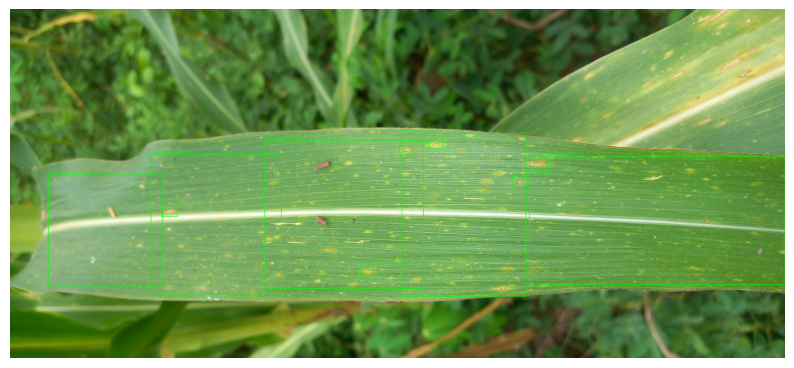

In [7]:
sample_image_id = train["Image_ID"].iloc[7]
visualize_sample(sample_image_id, train)

In [8]:
label_mapping = {label: idx+1 for idx, label in enumerate(train["class"].unique())}
reverse_label_mapping = {idx: label for label, idx in label_mapping.items()}
print("Label Mapping:", label_mapping)

Label Mapping: {'Pepper_Bacterial_Spot': 1, 'Pepper_Fusarium': 2, 'Corn_Cercospora_Leaf_Spot': 3, 'Corn_Common_Rust': 4, 'Tomato_Early_Blight': 5, 'Pepper_Septoria': 6, 'Tomato_Septoria': 7, 'Pepper_Leaf_Curl': 8, 'Pepper_Leaf_Mosaic': 9, 'Corn_Streak': 10, 'Corn_Healthy': 11, 'Pepper_Healthy': 12, 'Tomato_Healthy': 13, 'Pepper_Late_Blight': 14, 'Tomato_Late_Blight': 15, 'Pepper_Cercospora': 16, 'Tomato_Fusarium': 17, 'Pepper_Leaf_Blight': 18, 'Tomato_Leaf_Curl': 19, 'Tomato_Bacterial_Spot': 20, 'Tomato_Mosaic': 21, 'Pepper_Early_Blight': 22, 'Corn_Northern_Leaf_Blight': 23}


In [9]:
train["class_id"] = train["class"].map(label_mapping)

In [10]:
train_images, val_images = train_test_split(train["Image_ID"].unique(), test_size=0.2, random_state=42)
train_data = train[train["Image_ID"].isin(train_images)]
val_data = train[train["Image_ID"].isin(val_images)]

In [11]:
def get_train_transform():
    return A.Compose(
        [
            A.OneOf(
                [
                    A.MotionBlur(p=0.2),
                    A.MedianBlur(blur_limit=3, p=0.1),
                    A.Blur(blur_limit=3, p=0.1),
                ],
                p=0.2,
            ),
            A.HorizontalFlip(p=0.6),
            A.VerticalFlip(p=0.6),
            ToTensorV2(p=1.0),
        ],
        bbox_params=A.BboxParams(
            format='pascal_voc',  # Ensure pascal_voc format
            min_area=1,
            label_fields=['labels']
        ),
    )
def get_valid_transform():
    return A.Compose(
        [
            A.HorizontalFlip(p=0.6),
            ToTensorV2(p=1.0),
        ],
        bbox_params=A.BboxParams(
            format='pascal_voc',  # Ensure pascal_voc format
            min_area=1,
            label_fields=['labels']
        ),
    )

## Model data preparation

In [12]:
class CropDiseaseDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        """
        Initialize the dataset.

        Args:
        - dataframe: DataFrame containing annotations.
        - image_dir: Directory path for images.
        - transforms: Albumentations transforms to apply to the images and bounding boxes.
        """
        super().__init__()
        self.image_ids = dataframe['Image_ID'].unique()  # Unique image IDs
        self.df = dataframe  # Full DataFrame
        self.image_dir = image_dir  # Path to the images
        self.transforms = transforms  # Transformations to apply

    def __getitem__(self, index: int):
        """
        Fetch a data sample at a given index.

        Args:
        - index: Index of the sample.

        Returns:
        - image: Transformed image tensor.
        - target: Dictionary with bounding box data and metadata.
        - image_id: Unique identifier for the image.
        """
        image_id = self.image_ids[index]
        records = self.df[self.df['Image_ID'] == image_id]

        # Load and preprocess the image
        image = cv2.imread(f'{self.image_dir}{image_id}', cv2.IMREAD_COLOR)  # Load image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)  # Convert to RGB
        image /= 255.0  # Normalize to [0, 1]
        height, width, _ = image.shape

        # Get bounding box coordinates and ensure they are valid
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        if ((boxes[:, 2] - boxes[:, 0]) <= 0).any() or ((boxes[:, 3] - boxes[:, 1]) <= 0).any():
            return self.__getitem__(np.random.randint(len(self)))  # Skip invalid boxes

        # Calculate the area of each bounding box
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        area = torch.as_tensor(area, dtype=torch.float32)

        # Get class labels
        labels = records['class_id'].values
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Set iscrowd to zero for all instances
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        # Target dictionary
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': labels,
            'image_id': torch.tensor([index]),
            'area': area,
            'iscrowd': iscrowd
        }

        # Apply transformations if provided
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'].tolist(),
                'labels': labels.tolist()
            }
            transformed = self.transforms(**sample)
            image = transformed['image']
            target['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
            target['labels'] = torch.tensor(transformed['labels'], dtype=torch.int64)

        return image, target, image_id

    def __len__(self) -> int:
        """Return the length of the dataset."""
        return len(self.image_ids)

    def compute_num_categories(self):
        """Compute the number of unique categories per image."""
        self.num_categories = {}
        for image_id in self.image_ids:
            records = self.df[self.df['Image_ID'] == image_id]
            num_categories = len(records['class_id'].unique())
            self.num_categories[image_id] = num_categories

In [13]:
# Create Dataset objects with different transforms
train_dataset = CropDiseaseDataset(dataframe=train_data, image_dir=IMG_PATH, transforms=get_train_transform())
val_dataset = CropDiseaseDataset(dataframe=val_data, image_dir=IMG_PATH, transforms=get_valid_transform())

In [14]:
# Create DataLoader objects
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)), num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)), num_workers=4)
# Check DataLoader for validation
for batch_idx, (images, bboxes, labels) in enumerate(val_loader):
    print(f"Validation Batch {batch_idx + 1}:")
    print("Images shape:", [img.shape for img in images])
    print("Bounding boxes:", bboxes)
    print("Labels:", labels)
    break

Validation Batch 1:
Images shape: [torch.Size([3, 3060, 4080]), torch.Size([3, 1836, 4080]), torch.Size([3, 1836, 4080]), torch.Size([3, 2560, 1920])]
Bounding boxes: ({'boxes': tensor([[2742.6489, 1919.6179, 3205.2410, 2468.1240],
        [1789.7971, 1222.3236, 2068.1699, 1874.2352]]), 'labels': tensor([8, 8]), 'image_id': tensor([0]), 'area': tensor([253734.7344, 181474.3125]), 'iscrowd': tensor([0, 0])}, {'boxes': tensor([[2316.9675, 1033.2333, 3098.6628, 1370.6299],
        [2554.6333,  997.7816, 2911.0271, 1374.1045],
        [ 573.6182,  529.9500, 2080.7717, 1612.4308],
        [ 119.7484, 1388.3591,  986.4990, 1818.8499],
        [3368.6008,  782.9974, 4032.1985, 1075.4078],
        [ 185.3250,  698.4337, 1248.8049, 1163.1356],
        [1214.5914, 1185.9430, 1790.5243, 1582.2225],
        [   0.0000,  611.4875, 1254.0869, 1836.0000],
        [2122.9497,  583.3711, 2946.8228, 1145.6989],
        [2135.5137,  450.4026, 2625.9121,  892.2971]]), 'labels': tensor([11, 11, 11, 11, 11,

In [15]:
for batch_idx, (images, bboxes, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx}:")
    for i, bbox in enumerate(bboxes):
        print(f"Image {i} Bounding Boxes: {bbox}")
    break

Batch 0:
Image 0 Bounding Boxes: {'boxes': tensor([[  84.3556, 1376.3411,  868.8629, 1814.9567],
        [1957.0503,  260.1204, 3022.7429, 1081.1189],
        [ 868.8629,  310.7300, 1892.3777, 1109.2354],
        [2331.0269, 1626.5769, 3233.6321, 1820.5800],
        [  25.3067,  254.4972,  798.5665, 1162.6565],
        [1254.0868, 1491.6182, 2252.2949, 1823.3916],
        [2935.5754,   66.1175, 4080.0000, 1069.8724]]), 'labels': tensor([11, 11, 11, 11, 11, 11, 11]), 'image_id': tensor([2849]), 'area': tensor([ 344097.1250,  874932.0000,  817282.0625,  175108.1562,  702243.0625,
         331178.8750, 1148721.8750]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0])}
Image 1 Bounding Boxes: {'boxes': tensor([[3406.9277, 3034.9890, 3603.9260, 3328.9814],
        [2927.7185, 3436.5979, 3240.7476, 3612.4324],
        [2572.8606, 2191.5955, 2719.8223, 2496.7551],
        [1529.1903, 2106.1050, 1746.2787, 2326.1729],
        [3432.9124, 1947.3728, 3614.7671, 2244.3987],
        [3013.3484, 3859.4988, 

# Modeling

In [16]:
# Number of classes (23 diseases + 1 background)
num_classes = len(label_mapping) + 1
model = get_model(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 213MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Training

In [17]:
from torch.amp import GradScaler, autocast

def train_one_epoch(model, optimizer, data_loader, device, scaler, accumulation_steps=1):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for batch_idx, (images, targets, _) in enumerate(tqdm(data_loader)):  # Unpack (images, targets, image_id)
        # Move images and targets to device
        images = list(img.to(device) for img in images)
        targets = [
            {key: value.to(device) for key, value in target.items()}
            for target in targets
        ]

        # Mixed precision forward pass
        with autocast(device_type="cuda"):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss = losses / accumulation_steps  # Scale loss for gradient accumulation
            total_loss += loss.item()

        # Backward pass with mixed precision
        scaler.scale(loss).backward()

        # Perform optimizer step after accumulation_steps
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(data_loader):
            scaler.step(optimizer)  # Update weights
            scaler.update()        # Adjust scaler for next iteration
            optimizer.zero_grad()  # Clear gradients for the next step

    return total_loss / len(data_loader)

# Validation Loop
def validate(model, data_loader, device):
    model.eval()
    total_loss = 0
    metric = MeanAveragePrecision(iou_thresholds=[0.5], iou_type="bbox")  # mAP metric

    with torch.no_grad():
        for images, targets, _ in tqdm(data_loader):  # Unpack (images, targets, image_id)
            # Move images and targets to device
            images = list(img.to(device) for img in images)
            targets = [
                {key: value.to(device) for key, value in target.items()}
                for target in targets
            ]

            # Get model predictions
            with autocast(device_type="cuda"):
                outputs = model(images)

            # Update mAP metric
            metric.update(outputs, targets)

    # Compute mAP
    mAP_result = metric.compute()

    return mAP_result["map"]

In [18]:
# Optimizer and Learning Rate Scheduler
initial_lr = 0.005  # Initial learning rate
momentum = 0.9
weight_decay = 0.0005
num_epochs = 12
accumulation_steps = 2  # Number of steps for gradient accumulation
scaler = GradScaler("cuda")  # Initialize GradScaler for mixed precision

# Create the optimizer with the learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum, weight_decay=weight_decay)
# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

lr=0.005,mom=0.9,decay=0.0005,epo=12,acum=2,bat=4

In [19]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training
    train_loss = train_one_epoch(model, optimizer, train_loader, device, scaler, accumulation_steps)

    # Validation
    mAP = validate(model, val_loader, device)

    # Step the learning rate scheduler
    lr_scheduler.step()

    print(
        f"Epoch {epoch + 1}/{num_epochs}, "
        f"Train Loss: {train_loss:.4f},"
        f"mAP@0.5: {mAP:.4f}"
    )

Epoch 1/12


100%|██████████| 246/246 [02:42<00:00,  1.51it/s]


Epoch 1/12, Train Loss: 0.5003,mAP@0.5: 0.0870
Epoch 2/12


100%|██████████| 246/246 [02:42<00:00,  1.51it/s]


Epoch 2/12, Train Loss: 0.4304,mAP@0.5: 0.1339
Epoch 3/12


100%|██████████| 246/246 [02:43<00:00,  1.51it/s]


Epoch 3/12, Train Loss: 0.4177,mAP@0.5: 0.1590
Epoch 4/12


100%|██████████| 246/246 [02:44<00:00,  1.50it/s]


Epoch 4/12, Train Loss: 0.3915,mAP@0.5: 0.1711
Epoch 5/12


100%|██████████| 246/246 [02:43<00:00,  1.51it/s]


Epoch 5/12, Train Loss: 0.3888,mAP@0.5: 0.1763
Epoch 6/12


100%|██████████| 246/246 [02:43<00:00,  1.50it/s]


Epoch 6/12, Train Loss: 0.3855,mAP@0.5: 0.1797
Epoch 7/12


100%|██████████| 246/246 [02:43<00:00,  1.50it/s]


Epoch 7/12, Train Loss: 0.3856,mAP@0.5: 0.1810
Epoch 8/12


100%|██████████| 246/246 [02:43<00:00,  1.50it/s]


Epoch 8/12, Train Loss: 0.3832,mAP@0.5: 0.1849
Epoch 9/12


100%|██████████| 246/246 [02:44<00:00,  1.50it/s]


Epoch 9/12, Train Loss: 0.3829,mAP@0.5: 0.1824
Epoch 10/12


100%|██████████| 246/246 [02:44<00:00,  1.50it/s]


Epoch 10/12, Train Loss: 0.3823,mAP@0.5: 0.1866
Epoch 11/12


100%|██████████| 246/246 [02:42<00:00,  1.51it/s]


Epoch 11/12, Train Loss: 0.3822,mAP@0.5: 0.1846
Epoch 12/12


100%|██████████| 246/246 [02:43<00:00,  1.51it/s]


Epoch 12/12, Train Loss: 0.3825,mAP@0.5: 0.1847


In [20]:
torch.save(model.state_dict(), f"faster_rcnn_12_epoch.pth")

#import shutil
#shutil.copyfile(f"faster_rcnn_1_epoch.pth", f"{PATH}/models/faster_rcnn_1_epoch.pth")

### Validation Visualization Helpers

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(model, data_loader, device, num_images=2):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, targets, image_ids in data_loader:
            # Move images to device
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for i in range(len(images)):
                # Skip if we've already shown enough images
                if images_shown >= num_images:
                    return

                fig, ax = plt.subplots(1, figsize=(12, 8))

                # Convert tensor to numpy array for visualization
                img = images[i].permute(1, 2, 0).cpu().numpy()
                img = img * 255  # Scale back pixel values if normalized
                ax.imshow(img.astype(np.uint8))

                # Ground truth boxes
                gt_boxes = targets[i]["boxes"].cpu().numpy()
                gt_labels = targets[i]["labels"].cpu().numpy()

                for box, label in zip(gt_boxes, gt_labels):
                    xmin, ymin, xmax, ymax = box
                    rect = patches.Rectangle(
                        (xmin, ymin), xmax - xmin, ymax - ymin,
                        linewidth=2, edgecolor="green", facecolor="none"
                    )
                    ax.add_patch(rect)
                    ax.text(
                        xmin, ymin - 10, f"GT: {label}", color="green", fontsize=12, fontweight="bold"
                    )

                # Predicted boxes
                pred_boxes = outputs[i]["boxes"].cpu().numpy()
                pred_scores = outputs[i]["scores"].cpu().numpy()
                pred_labels = outputs[i]["labels"].cpu().numpy()

                for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
                    xmin, ymin, xmax, ymax = box
                    rect = patches.Rectangle(
                        (xmin, ymin), xmax - xmin, ymax - ymin,
                        linewidth=2, edgecolor="red", facecolor="none"
                    )
                    ax.add_patch(rect)
                    ax.text(
                        xmin, ymin - 10, f"Pred: {label} ({score:.2f})", color="red", fontsize=12, fontweight="bold"
                    )

                ax.set_title(f"Image ID: {image_ids[i]}")
                plt.axis("off")
                plt.show()

                images_shown += 1

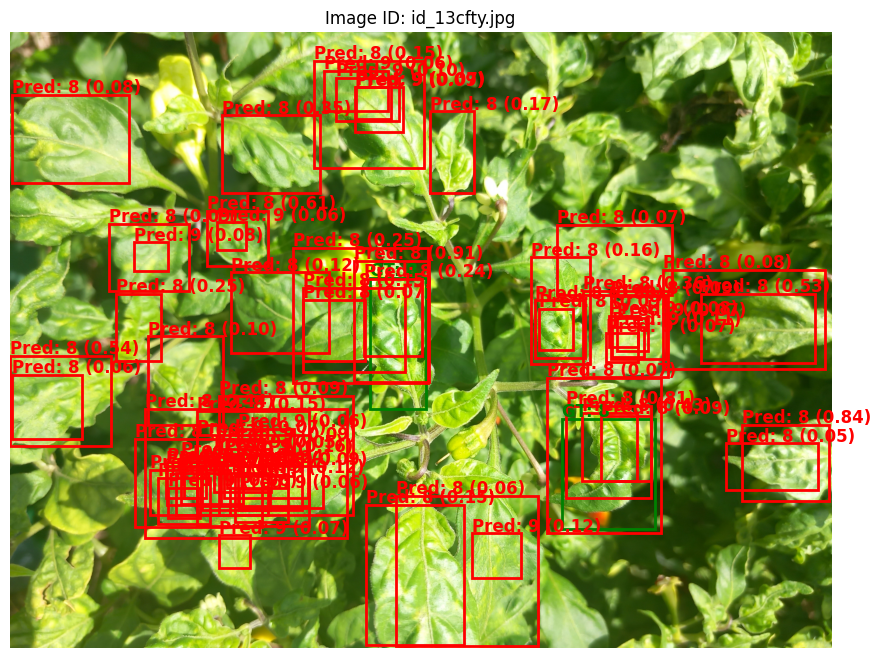

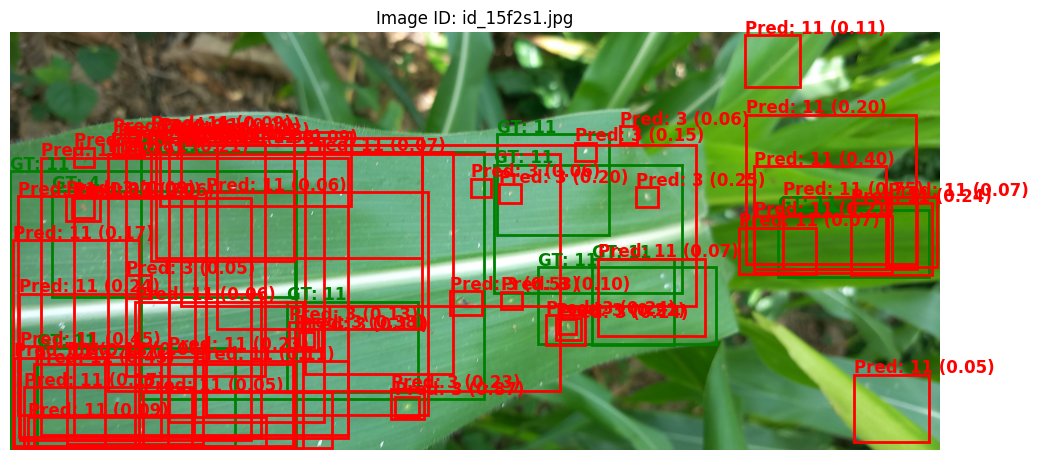

In [22]:
# Visualize predictions on 2 images
visualize_predictions(model, val_loader, device, num_images=2)

# Submission

In [23]:
class TestDataset(Dataset):
    def __init__(self, image_ids, image_dir, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f"{self.image_dir}/{image_id}", cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        if self.transforms:
            image = self.transforms(image=image)["image"]

        # Convert to tensor
        image = torch.tensor(image).permute(2, 0, 1)  # (H, W, C) -> (C, H, W)

        return image, image_id

    def __len__(self):
        return len(self.image_ids)


In [24]:
def run_inference(model, data_loader, device, score_threshold=0.5):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, image_ids in tqdm(data_loader):
            images = list(img.to(device) for img in images)

            # Perform inference
            outputs = model(images)

            for image_id, output in zip(image_ids, outputs):
                boxes = output["boxes"].cpu().numpy()
                scores = output["scores"].cpu().numpy()
                labels = output["labels"].cpu().numpy()

                image_predictions = []

                # Filter predictions based on confidence score threshold
                for box, score, label in zip(boxes, scores, labels):
                    if score >= score_threshold:
                        image_predictions.append({
                            "Image_ID": image_id,
                            "confidence": score,
                            "class": label,
                            "ymin": box[1],
                            "xmin": box[0],
                            "ymax": box[3],
                            "xmax": box[2],
                        })

                # Add at least one prediction for each image
                if not image_predictions and len(scores) > 0:
                    # Get the highest-scoring prediction
                    best_idx = scores.argmax()
                    image_predictions.append({
                        "Image_ID": image_id,
                        "confidence": scores[best_idx],
                        "class": labels[best_idx],
                        "ymin": boxes[best_idx][1],
                        "xmin": boxes[best_idx][0],
                        "ymax": boxes[best_idx][3],
                        "xmax": boxes[best_idx][2],
                    })

                # Add all valid predictions to the main list
                predictions.extend(image_predictions)

    return predictions


def save_predictions_to_csv(predictions, output_file):
    df = pd.DataFrame(predictions)
    df["class"] = df["class"].map(reverse_label_mapping)
    df.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

In [25]:
test.columns

Index(['Image_ID', 'confidence', 'class', 'ymin', 'xmin', 'ymax', 'xmax'], dtype='object')

In [26]:
# Create Dataset objects with different transforms
def collate_fn(batch):
    images, image_ids = zip(*batch)
    return list(images), list(image_ids)

test_dataset = TestDataset(image_ids=test["Image_ID"].unique(), image_dir=IMG_PATH)
test_loader = DataLoader(
    test_dataset,
    batch_size=4, 
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [27]:
predictions = run_inference(model, test_loader, device, score_threshold=0.5)

100%|██████████| 526/526 [05:44<00:00,  1.52it/s]


In [28]:
test['Image_ID'].nunique()

2101

In [29]:
save_predictions_to_csv(predictions, "submission_fastrcnn_2_12epoch.csv")

Predictions saved to submission_fastrcnn_2_12epoch.csv
